#  Building a State of the Art Bacterial Classifier with Openvino

The fast.ai library has been breaking records as students use it to produce state of the art results on a myriad of tasks. Some examples given in the course include environmental sound classification and handwritten devanagari prediction.

In this notebook we'll use the library for state of the art bacteria classification with the [DIBaS dataset](http://misztal.edu.pl/software/databases/dibas/). DIBaS (Digital Image of Bacterial Species) contains 660 images, with 33 different genera and species of bacteria.

You can also check out the full blog post on [Building a Bacterial Classifier with fast.ai](https://blog.paperspace.com/building-a-state-of-the-art-bacterial-classifier-with-paperspace-gradient-and-fast-ai/) by Harsh Sikka.

## Load libraries

In [15]:
import os
import requests
import urllib.request
import zipfile
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import error_rate
from bs4 import BeautifulSoup

## Check the bacteria dataset

In [16]:
len(os.listdir(('/storage/data/dibas_images/')))

671

## Train our model

In [7]:
bs = 64
fnames = get_image_files('/storage/data/dibas_images/')
fnames[:5]

[PosixPath('/storage/data/dibas_images/Bacteroides.fragilis_0015.tif'),
 PosixPath('/storage/data/dibas_images/Enterococcus.faecalis_0007.tif'),
 PosixPath('/storage/data/dibas_images/Lactobacillus.salivarius_0004.tif'),
 PosixPath('/storage/data/dibas_images/Propionibacterium.acnes_0002.tif'),
 PosixPath('/storage/data/dibas_images/Enterococcus.faecium_0018.tif')]

In [8]:
np.random.seed(42)
pat = r'/([^/]+)_\d+.tif$'
data = ImageDataBunch.from_name_re('/storage/data/dibas_images/', fnames, pat, ds_tfms=get_transforms(), size=24, bs=bs).normalize(imagenet_stats)
print(data)

ImageDataBunch;

Train: LabelList (536 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
Bacteroides.fragilis,Enterococcus.faecalis,Propionibacterium.acnes,Enterococcus.faecium,Staphylococcus.aureus
Path: /storage/data/dibas_images;

Valid: LabelList (133 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
Micrococcus.spp,Lactobacillus.crispatus,Propionibacterium.acnes,Lactobacillus.casei,Enterococcus.faecalis
Path: /storage/data/dibas_images;

Test: None


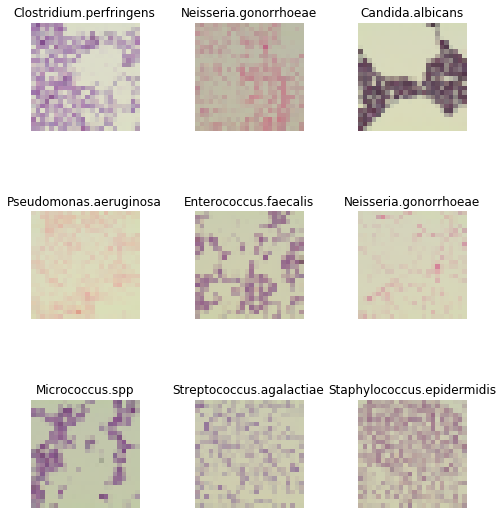

In [9]:
data.show_batch(rows=3, figsize=(7,8))


## Find optimal learning rate

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


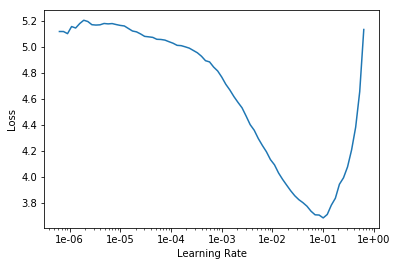

In [10]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.save('stage-1-50')
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-2,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,5.583645,2834790875136.000000,0.969925,00:03
1,6.328524,346202.812500,0.954887,00:02
2,5.625596,869.764771,0.887218,00:02


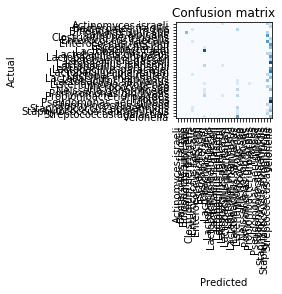

In [13]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix(plot_txt=False)



# Predict an image

(Category Veionella,
 tensor(31),
 tensor([4.8771e-03, 8.8593e-03, 1.4517e-02, 4.1809e-04, 2.8731e-02, 1.4793e-01,
         3.1388e-03, 2.7503e-02, 1.6903e-02, 2.4245e-03, 3.2560e-03, 4.7755e-03,
         1.5479e-03, 1.6409e-02, 8.7411e-05, 3.1454e-04, 6.0510e-04, 1.3459e-03,
         4.8764e-03, 8.3923e-03, 5.3115e-02, 2.1965e-02, 1.3272e-01, 3.4580e-02,
         2.2349e-02, 1.8894e-02, 4.1613e-02, 1.0542e-02, 6.6474e-03, 3.2258e-02,
         5.0192e-02, 2.7821e-01]))

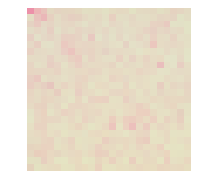

In [14]:
img = learn.data.train_ds[0][0]
img.show()

learn.predict(img)

# Upload model and deploy it w/ gradient

# Train with the SDK as an experiment

# Test deployed endpoint for performance

In [17]:
import json
import requests
deployment_url = "https://clpvt0s6x.paperspacegradient.com/model-serving/deqj8z1ium0gi1"
result = requests.get("{}/metadata".format(deployment_url))

try:
    result_dic = json.loads(result.text)
except ValueError:
    result_dic="The server response is not json format: {}",format(result.text)

print(result_dic)

{'modelSpec': {'name': 'bacteria_classifier', 'version': '1'}, 'metadata': {'signature_def': {'@type': 'type.googleapis.com/tensorflow.serving.SignatureDefMap', 'signatureDef': {'serving_default': {'inputs': {'image': {'name': 'image_3:0', 'dtype': 'DT_FLOAT', 'tensorShape': {'dim': [{'size': '1'}, {'size': '3'}, {'size': '24'}, {'size': '24'}]}}}, 'outputs': {'bacterialclassifier': {'name': 'bacterialclassifier_3:0', 'dtype': 'DT_FLOAT', 'tensorShape': {'dim': [{'size': '1'}, {'size': '32'}]}}}, 'methodName': 'tensorflow/serving/predict'}}}}}


In [18]:
!python rest_serving_client.py --images_numpy_path /storage/data/dibas_batch/val_batch.npy --labels_numpy_path /storage/data/dibas_batch/val_labels.npy --input_name image --output_name bacterialclassifier --rest_port 8001 --transpose_input False --rest_url https://clpvt0s6x.paperspacegradient.com/model-serving/deqj8z1ium0gi1

Image data range: 0 : 255
Start processing:
	Model name: resnet
	Iterations: 64
	Images numpy path: /storage/data/dibas_batch/val_batch.npy
	Images in shape: (64, 3, 24, 24)

output shape: (1, 32)
Iteration 1; Processing time: 60.93 ms; speed 16.41 fps
output shape: (1, 32)
Iteration 2; Processing time: 122.39 ms; speed 8.17 fps
output shape: (1, 32)
Iteration 3; Processing time: 98.59 ms; speed 10.14 fps
output shape: (1, 32)
Iteration 4; Processing time: 99.05 ms; speed 10.10 fps
output shape: (1, 32)
Iteration 5; Processing time: 100.28 ms; speed 9.97 fps
output shape: (1, 32)
Iteration 6; Processing time: 189.39 ms; speed 5.28 fps
output shape: (1, 32)
Iteration 7; Processing time: 100.16 ms; speed 9.98 fps
output shape: (1, 32)
Iteration 8; Processing time: 102.68 ms; speed 9.74 fps
output shape: (1, 32)
Iteration 9; Processing time: 98.38 ms; speed 10.16 fps
output shape: (1, 32)
Iteration 10; Processing time: 98.74 ms; speed 10.13 fps
output shape: (1, 32)
Iteration 11; Processi

# Save Model to ONNX

In [ ]:
from torch.autograd import Variable
sz = 24
#model = torch.load('Weights.h5')
model_name = "bacterial_classifier3.onnx"

dummy_input = Variable(torch.randn(1, 3, sz, sz)) # for iOS app, we predict only 1 image at a time, we don't use batch
torch.onnx.export(learn.model, dummy_input, model_name, \
                  input_names=['image'], output_names=['bacterialclassifier'], verbose=True)

In [ ]:
img = learn.data.train_ds[0][0]
img.show()

learn.predict(img)


In [13]:
!mkdir /storage/data/dibas_batch/

In [15]:
val_batch=[np.array(learn.data.valid_ds[i][0].data) for i in range(64)]
val_batch=np.array(val_batch)
val_batch.shape
val_batch=val_batch.transpose([0,1,3,2])
val_batch.shape
np.save('/storage/data/dibas_batch/val_batch', val_batch)
val_labels=[np.array(learn.data.valid_ds[i][0].data) for i in range(64)]
val_labels=np.array(val_labels)
val_labels.shape
val_labels=val_labels.transpose([0,1,3,2])
val_labels.shape
np.save('/storage/data/dibas_batch/val_labels', val_labels)

## Convert to OpenVINO IR

In [ ]:
!python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py --input_model=bacterial_classifier3.onnx -o .

In [ ]:
mv l_openvino_toolkit_p_2020.1.023.tgz /storage

In [ ]:
ls